# Topography in the direction of the event

Illustration of the topography in the direction of KM3-230213A using bathymetric data from EMODnet. A sectional view along the incoming direction and position of the event is provided, with the sea shown in blue and the seabed and the rock beneath in brown. (Figure 9)

In [1]:
import astropy.coordinates
import astropy.time
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as si

from km3astro.coord import local_event

Depth data should be downloaded on EMODnet website:
1. Go to https://emodnet.ec.europa.eu/geoviewer/.
2. In the Catalogue tab, choose "EMODnet BAthymetry" / "Depth" / "Mean depth natural color (with land)".
3. Click on the Download icon on the left.
4. Click on "Click here to select an area on the map" on the right.
5. Select the area you want (coordinates are given in bottom left), conservative range is $13<\text{lon}<19$, and $34<\text{lat}<38$.
6. In the right panel, select "esriAscii" as format and click on Download button next to it.

### KM3NeT input directions

In [2]:
km3net_coords = (15.975552, 36.292201)  
lon_km3net, lat_km3net = np.deg2rad(km3net_coords)
time = astropy.time.Time(59988.05333, format="mjd")
earth_radius = 6371e3  # Earth radius in meters
pos_track_nominal = (-245.44, 433.57, -3170.07)  # X/Y and depth of track in meters
dir_track_nominal = (0.98234, 0.18676, -0.01110)  # unit vector of track direction
error_alt = 1.5  # in degrees

In [13]:
-3170.07 - 279.93

-3450.0

In [3]:
# Convert to local theta/phi
phi = np.arctan2(dir_track_nominal[1], dir_track_nominal[0])
theta = np.arccos(dir_track_nominal[2])
# Use km3astro to get altitude/azimuth and source direction in horizontal coordinates
ev = local_event(theta, phi, time, location="arca")
alt_nominal, az_nominal = ev.alt.rad[0], ev.az.rad[0]
def altaz_to_dirsrc(alt, az):
    return (np.sin(az)*np.cos(alt), np.cos(az)*np.cos(alt), np.sin(alt))
dir_src_nominal = altaz_to_dirsrc(alt_nominal, az_nominal)

### Importing sea depth file

In [4]:
def read_depthdata(fname: str):
    """Read sea depth data from the EMODNet ESRI ascii file.
    
    Args:
        fname (str): path to input ESRI ascii file
    """
    # The first 6 lines of the files are metadata on the grid span
    metadata = np.genfromtxt(fname, max_rows=6, converters = {0: lambda s: s}, encoding="utf-8")
    metadata = {m[0]: m[1] for m in metadata}
    # Longitudes and latitutes are defined from the bottom left corner with some step size
    lon = metadata["xllcenter"] + metadata["cellsize"] * np.arange(metadata["ncols"])
    lat = metadata["yllcenter"] + metadata["cellsize"] * np.arange(metadata["nrows"])
    # Latitudes should be flipped as the depth array is defined from the North-West corner
    lat = np.flipud(lat)
    grid_lon, grid_lat = np.meshgrid(lon, lat)  
    # Grid of depth in meters is defined from the North-West corner of above grid
    grid_depth = np.loadtxt(fname, skiprows=6)
    grid_depth[grid_depth < -10000] = 0
    return lon, lat, grid_lon, grid_lat, grid_depth

lon, lat, grid_lon, grid_lat, grid_depth = read_depthdata("../data/external/marine/emodnet.esriAscii")
# Interpolation of sea depth at given latitude / longitude
fdepth = si.RegularGridInterpolator((lon, lat), grid_depth.T, bounds_error=False)

### Compute track trajectory and depths

In [5]:
def coords_track(t: np.ndarray, dir_src: tuple):
    """Returns the latitude/longitude of the track as a function of its distance to KM3NeT.
    
    Args:
        t (np.ndarray): array of distances to KM3NeT in meters
        dir_src (tuple): unit vector pointing to the direction of the source in local coordinates at the detector
        
    Returns:
        np.ndarray: array with two columns corresponding the longitude and latitude of the track for input distances
    """
    # track movement with respect to horizontal coords (a,b,c) at KM3NeT
    a_t = pos_track_nominal[0] + dir_src[0] * t
    b_t = pos_track_nominal[1] + dir_src[1] * t
    c_t = (earth_radius + pos_track_nominal[2]) + dir_src[2] * t
    
    # convert back to geographical coordinates
    R_t = np.sqrt(a_t**2 + b_t**2 + c_t**2)
    lon_t = lon_km3net + np.arcsin(a_t/R_t)
    lat_t = lat_km3net + np.arcsin(b_t/R_t)
    
    # format in (N, 2) array with one column for latitude and one for longitude
    coords_t = np.array([np.rad2deg(lon_t), np.rad2deg(lat_t)]).T
    return coords_t

def depth_track(t: np.ndarray, dir_src: tuple):
    """Returns the depth of the track (with respect to sea level) as a function of its distance to KM3NeT.
    
    Args:
        t (np.ndarray): array of distances to KM3NeT in meters
        dir_src (tuple): unit vector pointing to the direction of the source in local coordinates at the detector
        
    Returns:
        np.ndarray: array of track depths in meters
    """
    # track movement with respect to horizontal coords (a,b,c) at KM3NeT
    a_t = pos_track_nominal[0] + dir_src[0] * t
    b_t = pos_track_nominal[1] + dir_src[1] * t
    c_t = (earth_radius + pos_track_nominal[2]) + dir_src[2] * t
    # convert back to geographical coordinates
    R_t = np.sqrt(a_t**2 + b_t**2 + c_t**2)
    depth_t = R_t - earth_radius
    return depth_t

def depth_seabed(t: np.ndarray, dir_src: tuple):
    """Returns the depth of the seabed at the lat/lon of the track as a function of its distance to KM3NeT.
    
    Args:
        t (np.ndarray): array of distances to KM3NeT in meters
        dir_src (tuple): unit vector pointing to the direction of the source in local coordinates at the detector
        
    Returns:
        np.ndarray: array of seabed depths in meters
    """
    return fdepth(coords_track(t, dir_src))

### Plot sea depth vs distance to KM3NeT

We focus on the 2D plane of Earch cross-section containing the KM3NeT track:
- the Y-axis goes from Earth center to KM3NeT
- the X-axis is uniquely defined in the above plan and such that X and Y forms an orthonormal coordinate system

Instead of plotting the track $(X(t), Y(t))$ where $t = \sqrt{X(t)^2 + Y(t)^2}$, we plot directly $(t, Y(t))$ as this provides directly a visualisation of track travelled distance.

In [6]:
t = np.linspace(0, 160e3, 1000)
# Track position in the 2D plane of Earth cross-section.
x_t = np.sqrt(1 - dir_src_nominal[2]**2) * t
y_t = pos_track_nominal[2] + dir_src_nominal[2] * t
# Water surface (assuming perfect sphere)
surf_water = np.sqrt(earth_radius**2 - x_t**2) - earth_radius
# Seabed level
surf_rock = np.sqrt((earth_radius + depth_seabed(t, dir_src=dir_src_nominal))**2 - x_t**2) - earth_radius

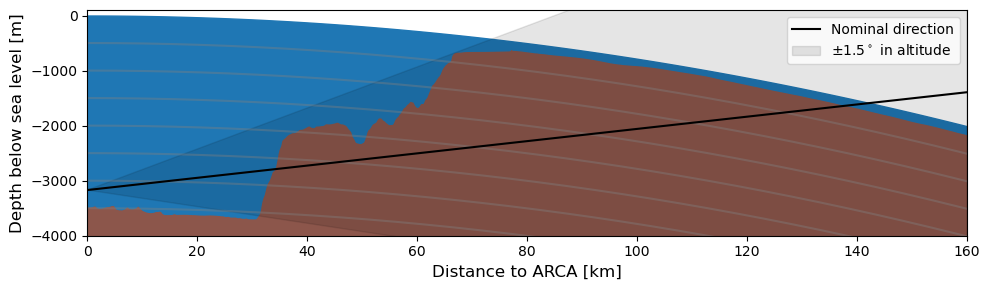

In [7]:
plt.figure(figsize=(10,3))
# Draw lines at constant water level (constant radius) 
for d in np.arange(500, 3501, 500):
    plt.plot(t/1000, np.sqrt((earth_radius - d)**2 - x_t**2) - earth_radius, color="grey", alpha=0.4)
# Draw sea bed
plt.fill_between(t/1000, -4000, surf_rock, color="tab:brown")
# Draw water
plt.fill_between(t/1000, surf_rock, surf_water, color="tab:blue")
# Track trajectory
plt.plot(t/1000, y_t, color="black", label='Nominal direction')
# Track trajectory for variation in zenith angle
y_t_minus = pos_track_nominal[2] + np.cos(np.arccos(dir_src_nominal[2]) - np.deg2rad(error_alt)) * t
y_t_plus = pos_track_nominal[2] + np.cos(np.arccos(dir_src_nominal[2]) + np.deg2rad(error_alt)) * t
plt.fill_between(t/1000, y_t_minus, y_t_plus, color='black', alpha=0.1, label=rf'$\pm {error_alt}^\circ$ in altitude')
# Customize axis and draw legend
plt.xlabel("Distance to ARCA [km]", fontsize=12)
plt.ylabel("Depth below sea level [m]", fontsize=12)
plt.xlim((0, 160))
plt.ylim((-4000, 100))
plt.legend()
plt.tight_layout()

### Compute travelled distance in the different mediums

In [8]:
mwe = {"water": 1, "rock": 2.6}  # density of water and rock

def get_distances(dir_src: tuple):
    """Compute travelled distances in different media for a given source direction."""
    t = np.linspace(0, 1000e3, 100000)
    dt = t[1] - t[0]  # step size in meters
    dseabed = depth_seabed(t, dir_src)
    dtrack = depth_track(t, dir_src)
    
    # Categorise each track step as air (0), water (1), or rock (2) based on its depth
    names = ["air", "water", "rock"]
    categ = np.zeros_like(t, dtype=int)
    categ[dtrack < 0] = 1  # water
    categ[dtrack < dseabed] = 2  # rock
    
    # We iterate through the array to get full history of traversed media
    elements = []
    curr_categ = None
    curr_length = 0
    tot_length = 0
    for c in np.flipud(categ):  # Start from origin
        if c == 0:  # Skip air
            continue
        elif curr_categ is None:  # First step not in air
            curr_categ = c
            curr_length = dt
            tot_length += dt
        elif c != curr_categ:  # Changing medium
            elements.append((curr_categ, curr_length/1000, tot_length/1000))
            curr_categ = c
            curr_length = dt
            tot_length += dt
        else:
            curr_length += dt
            tot_length += dt
    elements.append((curr_categ, curr_length/1000, tot_length/1000))
    return [(names[e], d, dt) for e, d, dt in elements]  # list of tuple with (element, distance, cumulative distance)

def get_kmwe(dir_src: tuple):
    """Compute km.w.e. distance for a given source direction."""
    d_mwe = 0
    dists = get_distances(dir_src)
    for n, d, _ in dists:
        d_mwe += mwe[n] * d
    return d_mwe

In [9]:
dist_nominal = get_distances(dir_src_nominal)
kmwe_nominal = get_kmwe(dir_src_nominal)
print("Nominal direction is consecutively crossing:")
for n, d, _ in dist_nominal:
    print(f"\t{n} -> {d:.0f} km")
print(f"TOTAL[nominal] = {dist_nominal[-1][2]:.0f} km, {kmwe_nominal:.0f} kmwe")

Nominal direction is consecutively crossing:
	water -> 4 km
	rock -> 104 km
	water -> 34 km
TOTAL[nominal] = 142 km, 309 kmwe


In [10]:
dir_src_pluserr = altaz_to_dirsrc(alt_nominal + np.deg2rad(error_alt), az_nominal)
dist_pluserr = get_distances(dir_src_pluserr)
kmwe_pluserr = get_kmwe(dir_src_pluserr)
print(f"TOTAL[alt+error] = {dist_pluserr[-1][2]:.0f} km, {kmwe_pluserr:.0f} kmwe")

TOTAL[alt+error] = 74 km, 75 kmwe


In [11]:
dir_src_minuserr = altaz_to_dirsrc(alt_nominal - np.deg2rad(error_alt), az_nominal)
dist_minuserr = get_distances(dir_src_minuserr)
kmwe_minuserr = get_kmwe(dir_src_minuserr)
print(f"TOTAL[alt-error] = {dist_minuserr[-1][2]:.0f} km, {kmwe_minuserr:.0f} kmwe")

TOTAL[alt-error] = 319 km, 745 kmwe
